<a href="https://colab.research.google.com/github/acse-2020/acse2020-acse9-finalreport-acse-jaq15/blob/main/notebooks/MLP/MLP_Al.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

The cells below handle all the necessary imports to run our models, making use of the public repo feeder_repo, linked <!-- [Text](link) -->
[here](https://github.com/acse-jaq15/feeder_repo).

In [1]:
# clone the feeder repo to get data_reader module and financial time series data
!git clone https://github.com/acse-jaq15/feeder_repo.git

Cloning into 'feeder_repo'...
remote: Enumerating objects: 150, done.
remote: Counting objects: 100% (150/150), done.
remote: Compressing objects: 100% (145/145), done.
remote: Total 150 (delta 73), reused 6 (delta 2), pack-reused 0
Receiving objects: 100% (150/150), 121.14 KiB | 429.00 KiB/s, done.
Resolving deltas: 100% (73/73), done.


In [2]:
# using '%' to enforce a permanent change of directory
%cd feeder_repo/

/content/feeder_repo


In [3]:
# checking contents listed correctly, should read:
# baseline_model.py data data_reader.py LICENSE README.md security_plotter.py
!ls

base_model.py  data  data_reader.py  LICENSE  README.md  security_plotter.py


In [4]:
import math
import sys
import keras
import os
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import *
from keras.utils.layer_utils import count_params
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, Callback
from keras.optimizers import RMSprop, SGD, Adam, Nadam
from keras.initializers import random_normal

In [5]:
# appending path with 'feeder_repo' string
sys.path.append('feeder_repo')

# import Data_Reader class from data_reader module
from feeder_repo.data_reader import Data_Reader
# import Baseline_Model class from base_model module
from feeder_repo.base_model import Base_Model
# import Security_Plotter class from security_plotter module
from feeder_repo.security_plotter import Security_Plotter

In [6]:
# checking if the notebook is running on a GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Fri Jul 23 11:08:48 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Handling the data
Here the Data_Reader class is used to read the time series data and extract training, test and validation sets, along with the relevant X and y values.

In [7]:
# storing the file to be read as a string
in_str = 'Al'
# storing the year of the time series to be used as test data
in_yr = 2019
# creating a variable to store the model name
model_str = 'MLP'
# setting our window_length to be 30 days
window_len = 30

In [8]:
# creating an instance of Data_Reader class
in_data = Data_Reader(in_str, in_yr)
# calling class method extract_train_test to generate training and test datasets
in_data.extract_train_test()
# calling class method extract_xy to generate X and y training and test datasets
in_data.extract_xy(window_len)

# assigning X_train and y_train
X_train = in_data.X_train
y_train = in_data.y_train

# assigning X_test and y_test
X_test = in_data.X_test
y_test = in_data.y_test

# assigning X_val_train and y_val_train
X_val_train = in_data.X_val_train
y_val_train = in_data.y_val_train

# assigning X_val_test and y_val_test
X_val_test = in_data.X_val_test
y_val_test = in_data.y_val_test

# Setting up wandb itegration
Here wandb is used to perform hyperparameter tuning.

In [9]:
# installing the wandb library and importing
%pip install wandb -q
import wandb
from wandb.keras import WandbCallback

     |████████████████████████████████| 1.8 MB 8.4 MB/s 
     |████████████████████████████████| 138 kB 52.4 MB/s 
     |████████████████████████████████| 97 kB 7.3 MB/s 
     |████████████████████████████████| 133 kB 61.7 MB/s 
     |████████████████████████████████| 177 kB 60.9 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
     |████████████████████████████████| 62 kB 806 kB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.26.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [10]:
!pip install wandb -qq

In [11]:
# logging in so the hyperparameter tunings sweeps can be saved
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [12]:
# configuring the sweep, making use of a random search methodology
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'mse',
      'goal': 'minimize'   
    },
    'parameters': {
        'epochs': {
            'values': [50, 100, 200]
        },
        'batch_size': {
            'values': [128, 64, 32]
        },
        'learning_rate': {
            'values': [0.005, 0.001, 0.0005]
        },
        'optimizer': {
            'values': ['adam', 'nadam', 'rmsprop', 'sgd']
        },
        'activation': {
            'values': ['relu', 'selu']
        }
    }
}

In [13]:
# wandb calls this training function to run through the hyperparameter search
def train():
    # default values for searching
    config_defaults = {
        'epochs': 100,
        'batch_size': 32,
        'learning_rate': 0.005,
        'optimizer': 'adam',
        'activation': 'tanh',
        'momentum': 0.9,
        'seed': 42
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config

    # setting keras model to sequential mode
    model = Sequential()

    # layer 1
    model.add(Dense(256, activation=config.activation, input_shape=(window_len, 1)))
    # layer 2
    model.add(Dense(128, activation=config.activation))
    # layer 3
    model.add(Dense(64, activation=config.activation))
    # layer 4
    model.add(Dense(32, activation=config.activation))
    # layer 5
    model.add(Flatten())
    # layer 6
    model.add(Dense(1))

    # Define the optimizer
    if config.optimizer=='sgd':
      optimizer = SGD(learning_rate=config.learning_rate, decay=1e-5, momentum=config.momentum, nesterov=True)
    elif config.optimizer=='rmsprop':
      optimizer = RMSprop(learning_rate=config.learning_rate, decay=1e-5)
    elif config.optimizer=='adam':
      optimizer = Adam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
    elif config.optimizer=='nadam':
      optimizer = Nadam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

    model.compile(loss = "mean_squared_error", optimizer=optimizer, metrics=['mean_squared_error', 'mean_absolute_error'])

    model.fit(X_val_train, y_val_train, batch_size=config.batch_size,
              epochs=config.epochs,
              validation_data=(X_val_test, y_val_test),
              callbacks=[WandbCallback(validation_data=(X_val_test, y_val_test)),
                          EarlyStopping(patience=10, restore_best_weights=True)])

In [14]:
# setting up our sweep_id
sweep_id = wandb.sweep(sweep_config, project='ACSE_9_'+model_str)

Create sweep with ID: rmbgjo26
Sweep URL: https://wandb.ai/acse-jaq15/ACSE_9_MLP/sweeps/rmbgjo26


In [15]:
# initialising a new sweep
wandb.agent(sweep_id, train, project='ACSE_9_'+model_str)

wandb: Agent Starting Run: hgbkk62p with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop
wandb: Currently logged in as: acse-jaq15 (use `wandb login --relogin` to force relogin)


Epoch 1/50
8/8 [==============================] - 16s 96ms/step - loss: 0.2659 - mean_squared_error: 0.2659 - mean_absolute_error: 0.4311 - val_loss: 0.0871 - val_mean_squared_error: 0.0871 - val_mean_absolute_error: 0.2451
Epoch 2/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0511 - mean_squared_error: 0.0511 - mean_absolute_error: 0.1739 - val_loss: 0.0256 - val_mean_squared_error: 0.0256 - val_mean_absolute_error: 0.1377
Epoch 3/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0205 - mean_squared_error: 0.0205 - mean_absolute_error: 0.1169 - val_loss: 0.0159 - val_mean_squared_error: 0.0159 - val_mean_absolute_error: 0.0948
Epoch 4/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0180 - mean_squared_error: 0.0180 - mean_absolute_error: 0.1039 - val_loss: 0.0292 - val_mean_squared_error: 0.0292 - val_mean_absolute_error: 0.1505
Epoch 5/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0264 - mean_squared_error: 0.0264 - m

epoch,49
loss,0.00613
mean_squared_error,0.00613
mean_absolute_error,0.06384
val_loss,0.00737
val_mean_squared_error,0.00737
val_mean_absolute_error,0.05698
_runtime,26
_timestamp,1627036667
_step,49
best_val_loss,0.00639


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▂▄▂▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▂▁▁▁▂▁▁▁▁▁▁▁
val_loss,█▃▂▃▅▂▂▂▃▂▂▂▃▂▂▂▁▂▂▁▂▂▁▁▁▁▂▁▁▂▂▂▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▂▃▅▂▂▂▃▂▂▂▃▂▂▂▁▂▂▁▂▂▁▁▁▁▂▁▁▂▂▂▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▃▅▇▄▄▂▃▂▂▂▄▂▂▂▂▂▂▂▂▂▁▂▁▂▂▁▁▂▃▂▁▁▁▁▂▂▁▁
_runtime,▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆████
_timestamp,▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 2b0bd628 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/200
16/16 [==============================] - 2s 37ms/step - loss: 0.0832 - mean_squared_error: 0.0832 - mean_absolute_error: 0.2103 - val_loss: 0.0305 - val_mean_squared_error: 0.0305 - val_mean_absolute_error: 0.1542
Epoch 2/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0081 - mean_squared_error: 0.0081 - mean_absolute_error: 0.0741 - val_loss: 0.0249 - val_mean_squared_error: 0.0249 - val_mean_absolute_error: 0.1343
Epoch 3/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0066 - mean_squared_error: 0.0066 - mean_absolute_error: 0.0639 - val_loss: 0.0158 - val_mean_squared_error: 0.0158 - val_mean_absolute_error: 0.0812
Epoch 4/200
16/16 [==============================] - 0s 6ms/step - loss: 0.0061 - mean_squared_error: 0.0061 - mean_absolute_error: 0.0627 - val_loss: 0.0146 - val_mean_squared_error: 0.0146 - val_mean_absolute_error: 0.0794
Epoch 5/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0048 - mean_squared_erro

epoch,97
loss,0.00123
mean_squared_error,0.00123
mean_absolute_error,0.02801
val_loss,0.00425
val_mean_squared_error,0.00425
val_mean_absolute_error,0.05001
_runtime,17
_timestamp,1627036695
_step,97
best_val_loss,0.00331


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▄▃▃▃▃▂▂▂▂▂▂▁▂▁▂▁▁▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▄▃▃▃▃▂▂▂▂▂▂▁▂▁▂▁▁▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▃▃▃▄▂▂▂▂▂▂▂▂▂▁▃▂▁▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▂
_runtime,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇█
_timestamp,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇█
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: h9l87tqm with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
8/8 [==============================] - 2s 108ms/step - loss: 0.1512 - mean_squared_error: 0.1512 - mean_absolute_error: 0.3195 - val_loss: 0.0173 - val_mean_squared_error: 0.0173 - val_mean_absolute_error: 0.1035
Epoch 2/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0069 - mean_squared_error: 0.0069 - mean_absolute_error: 0.0683 - val_loss: 0.0175 - val_mean_squared_error: 0.0175 - val_mean_absolute_error: 0.1038
Epoch 3/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0057 - mean_squared_error: 0.0057 - mean_absolute_error: 0.0613 - val_loss: 0.0182 - val_mean_squared_error: 0.0182 - val_mean_absolute_error: 0.1072
Epoch 4/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0047 - mean_squared_error: 0.0047 - mean_absolute_error: 0.0564 - val_loss: 0.0192 - val_mean_squared_error: 0.0192 - val_mean_absolute_error: 0.1122
Epoch 5/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0058 - mean_squared_error: 0.0058 - me

epoch,49
loss,0.00177
mean_squared_error,0.00177
mean_absolute_error,0.0334
val_loss,0.00527
val_mean_squared_error,0.00527
val_mean_absolute_error,0.05153
_runtime,10
_timestamp,1627036712
_step,49
best_val_loss,0.00518


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▂▂▂▂▁▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇▇▇█▅▅▅▇█▅▄▄▄▃▄▅▃▂▃▂▂▂▂▂▇▁▄▂▂▂▂▂▂▁▂▁▂▂▂▁
val_mean_squared_error,▇▇▇█▅▅▅▇█▅▄▄▄▃▄▅▃▂▃▂▂▂▂▂▇▁▄▂▂▂▂▂▂▁▂▁▂▂▂▁
val_mean_absolute_error,▆▆▇▇▄▃▄▇▇▄▄▄▃▃▄▆▂▂▂▂▁▂▁▂█▂▆▂▃▃▃▃▃▂▁▁▃▃▃▁
_runtime,▁▁▁▁▂▂▂▂▂▂▂▂▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▂▂▂▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: u1ek2y5g with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/100
8/8 [==============================] - 1s 67ms/step - loss: 0.2630 - mean_squared_error: 0.2630 - mean_absolute_error: 0.3906 - val_loss: 0.0223 - val_mean_squared_error: 0.0223 - val_mean_absolute_error: 0.1185
Epoch 2/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0112 - mean_squared_error: 0.0112 - mean_absolute_error: 0.0838 - val_loss: 0.0185 - val_mean_squared_error: 0.0185 - val_mean_absolute_error: 0.1092
Epoch 3/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0046 - mean_squared_error: 0.0046 - mean_absolute_error: 0.0536 - val_loss: 0.0158 - val_mean_squared_error: 0.0158 - val_mean_absolute_error: 0.0951
Epoch 4/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0050 - mean_squared_error: 0.0050 - mean_absolute_error: 0.0570 - val_loss: 0.0151 - val_mean_squared_error: 0.0151 - val_mean_absolute_error: 0.0947
Epoch 5/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0038 - mean_squared_error: 0.0038 

epoch,99
loss,0.00092
mean_squared_error,0.00092
mean_absolute_error,0.02402
val_loss,0.0041
val_mean_squared_error,0.0041
val_mean_absolute_error,0.04665
_runtime,14
_timestamp,1627036738
_step,99
best_val_loss,0.00409


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▅▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▅▅▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇██
_timestamp,▁▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: be2s2fw9 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/200
31/31 [==============================] - 2s 21ms/step - loss: 0.0801 - mean_squared_error: 0.0801 - mean_absolute_error: 0.2243 - val_loss: 0.0158 - val_mean_squared_error: 0.0158 - val_mean_absolute_error: 0.0817
Epoch 2/200
31/31 [==============================] - 0s 6ms/step - loss: 0.0196 - mean_squared_error: 0.0196 - mean_absolute_error: 0.1046 - val_loss: 0.0141 - val_mean_squared_error: 0.0141 - val_mean_absolute_error: 0.0878
Epoch 3/200
31/31 [==============================] - 0s 6ms/step - loss: 0.0244 - mean_squared_error: 0.0244 - mean_absolute_error: 0.1108 - val_loss: 0.0204 - val_mean_squared_error: 0.0204 - val_mean_absolute_error: 0.1205
Epoch 4/200
31/31 [==============================] - 0s 8ms/step - loss: 0.0143 - mean_squared_error: 0.0143 - mean_absolute_error: 0.0957 - val_loss: 0.0573 - val_mean_squared_error: 0.0573 - val_mean_absolute_error: 0.2198
Epoch 5/200
31/31 [==============================] - 0s 5ms/step - loss: 0.0140 - mean_squared_erro

epoch,18
loss,0.00496
mean_squared_error,0.00496
mean_absolute_error,0.05724
val_loss,0.0116
val_mean_squared_error,0.0116
val_mean_absolute_error,0.09323
_runtime,9
_timestamp,1627036754
_step,18
best_val_loss,0.00772


epoch,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██
loss,█▃▃▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁
mean_squared_error,█▃▃▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▃▃▃▂▂▂▂▂▁▁▂▁▁▁▁▁
val_loss,▂▂▃█▂▁▁▃▁▁▁▂▃▁▁▁▂▂▂
val_mean_squared_error,▂▂▃█▂▁▁▃▁▁▁▂▃▁▁▁▂▂▂
val_mean_absolute_error,▂▂▄█▂▁▁▃▁▂▁▃▄▁▂▂▂▂▂
_runtime,▁▃▃▃▃▃▅▅▅▅▅▆▆▆▆▆███
_timestamp,▁▃▃▃▃▃▅▅▅▅▅▆▆▆▆▆███
_step,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██


wandb: Agent Starting Run: 7k3mbpgw with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 3s 71ms/step - loss: 0.0518 - mean_squared_error: 0.0518 - mean_absolute_error: 0.1745 - val_loss: 0.0489 - val_mean_squared_error: 0.0489 - val_mean_absolute_error: 0.2034
Epoch 2/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0217 - mean_squared_error: 0.0217 - mean_absolute_error: 0.1270 - val_loss: 0.0358 - val_mean_squared_error: 0.0358 - val_mean_absolute_error: 0.1709
Epoch 3/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0155 - mean_squared_error: 0.0155 - mean_absolute_error: 0.1048 - val_loss: 0.0149 - val_mean_squared_error: 0.0149 - val_mean_absolute_error: 0.0957
Epoch 4/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0469 - val_loss: 0.0101 - val_mean_squared_error: 0.0101 - val_mean_absolute_error: 0.0644
Epoch 5/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0110 - mean_squared_error: 0.01

epoch,99
loss,0.00058
mean_squared_error,0.00058
mean_absolute_error,0.01911
val_loss,0.00272
val_mean_squared_error,0.00272
val_mean_absolute_error,0.03596
_runtime,18
_timestamp,1627036784
_step,99
best_val_loss,0.00272


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▂▂▂▂▂▂▂▂▁▁▃▁▁▂▁▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁
val_loss,█▃▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▂▂▂▂▂▃▂▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇██
_timestamp,▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 8kntoatb with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/50
31/31 [==============================] - 2s 21ms/step - loss: 0.0322 - mean_squared_error: 0.0322 - mean_absolute_error: 0.1249 - val_loss: 0.0183 - val_mean_squared_error: 0.0183 - val_mean_absolute_error: 0.0939
Epoch 2/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0080 - mean_squared_error: 0.0080 - mean_absolute_error: 0.0703 - val_loss: 0.0173 - val_mean_squared_error: 0.0173 - val_mean_absolute_error: 0.0835
Epoch 3/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0066 - mean_squared_error: 0.0066 - mean_absolute_error: 0.0643 - val_loss: 0.0136 - val_mean_squared_error: 0.0136 - val_mean_absolute_error: 0.0748
Epoch 4/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0058 - mean_squared_error: 0.0058 - mean_absolute_error: 0.0601 - val_loss: 0.0116 - val_mean_squared_error: 0.0116 - val_mean_absolute_error: 0.0752
Epoch 5/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0053 - mean_squared_error: 0.

epoch,45
loss,0.00162
mean_squared_error,0.00162
mean_absolute_error,0.03159
val_loss,0.00433
val_mean_squared_error,0.00433
val_mean_absolute_error,0.04834
_runtime,14
_timestamp,1627036806
_step,45
best_val_loss,0.0039


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
loss,█▄▄▃▃▃▂▂▂▂▂▁▂▂▁▁▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▄▃▃▃▂▂▂▂▂▁▂▂▁▁▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▅▅▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▂▁▂▁▁▁▁▁
val_loss,██▆▅▄▃▅▂▃▂▄▂▆▂▁▂▁▂▃▃▁▂▁▂▁▃▄▂▁▂▂▁▁▂▁▁▁▂▁▁
val_mean_squared_error,██▆▅▄▃▅▂▃▂▄▂▆▂▁▂▁▂▃▃▁▂▁▂▁▃▄▂▁▂▂▁▁▂▁▁▁▂▁▁
val_mean_absolute_error,█▇▅▆▄▄█▂▅▂▇▄█▃▂▂▂▄▅▅▁▃▃▂▂▅▆▃▁▃▄▁▂▃▂▁▂▃▂▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████


wandb: Agent Starting Run: zze9qd4h with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 2s 34ms/step - loss: 0.0371 - mean_squared_error: 0.0371 - mean_absolute_error: 0.1382 - val_loss: 0.0131 - val_mean_squared_error: 0.0131 - val_mean_absolute_error: 0.0882
Epoch 2/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0460 - val_loss: 0.0072 - val_mean_squared_error: 0.0072 - val_mean_absolute_error: 0.0585
Epoch 3/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - mean_absolute_error: 0.0339 - val_loss: 0.0054 - val_mean_squared_error: 0.0054 - val_mean_absolute_error: 0.0505
Epoch 4/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0288 - val_loss: 0.0046 - val_mean_squared_error: 0.0046 - val_mean_absolute_error: 0.0459
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0012 - mean_squared_erro

epoch,65
loss,0.00053
mean_squared_error,0.00053
mean_absolute_error,0.01812
val_loss,0.00243
val_mean_squared_error,0.00243
val_mean_absolute_error,0.03498
_runtime,15
_timestamp,1627036838
_step,65
best_val_loss,0.0023


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▁▂▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▂▁▁
val_loss,█▄▂▃▃▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▂▃▃▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▃▄▄▂▂▂▁▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂▁▁▁▁▁▂▂▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇█
_timestamp,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇█
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: cifv51ul with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/50
31/31 [==============================] - 2s 21ms/step - loss: 6.0282 - mean_squared_error: 6.0282 - mean_absolute_error: 1.3986 - val_loss: 0.0048 - val_mean_squared_error: 0.0048 - val_mean_absolute_error: 0.0495
Epoch 2/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0042 - mean_squared_error: 0.0042 - mean_absolute_error: 0.0504 - val_loss: 0.0041 - val_mean_squared_error: 0.0041 - val_mean_absolute_error: 0.0440
Epoch 3/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - mean_absolute_error: 0.0260 - val_loss: 0.0031 - val_mean_squared_error: 0.0031 - val_mean_absolute_error: 0.0389
Epoch 4/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0284 - val_loss: 0.0065 - val_mean_squared_error: 0.0065 - val_mean_absolute_error: 0.0700
Epoch 5/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0021 - mean_squared_error: 0.

epoch,28
loss,0.00112
mean_squared_error,0.00112
mean_absolute_error,0.02691
val_loss,0.00284
val_mean_squared_error,0.00284
val_mean_absolute_error,0.03655
_runtime,12
_timestamp,1627036858
_step,28
best_val_loss,0.00248


epoch,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▅▄▂█▂▃▄▂▂▃▃▂▂▁▂▁▂▆▁▂▁▃▁▄▂▁▁▁▂
val_mean_squared_error,▅▄▂█▂▃▄▂▂▃▃▂▂▁▂▁▂▆▁▂▁▃▁▄▂▁▁▁▂
val_mean_absolute_error,▄▃▂█▂▂▄▃▂▃▃▂▁▁▁▁▂▅▁▂▁▄▂▅▂▁▁▁▁
_runtime,▁▁▁▂▂▂▂▃▃▃▃▃▅▅▅▅▆▆▆▆▆▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▃▅▅▅▅▆▆▆▆▆▇▇▇▇████
_step,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇██


wandb: Agent Starting Run: roc1u310 with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/50
16/16 [==============================] - 1s 32ms/step - loss: 1.1640 - mean_squared_error: 1.1640 - mean_absolute_error: 0.5370 - val_loss: 7175.1704 - val_mean_squared_error: 7175.1704 - val_mean_absolute_error: 84.4662
Epoch 2/50
16/16 [==============================] - 0s 8ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 3/50
16/16 [==============================] - 0s 7ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 4/50
16/16 [==============================] - 0s 6ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 5/50
16/16 [==============================] - 0s 7ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val

epoch,10
loss,nan
mean_squared_error,nan
mean_absolute_error,nan
val_loss,nan
val_mean_squared_error,nan
val_mean_absolute_error,nan
_runtime,6
_timestamp,1627036875
_step,10
best_val_loss,7175.17041


epoch,▁▂▂▃▄▅▅▆▇▇█
loss,▁
mean_squared_error,▁
mean_absolute_error,▁
val_loss,▁
val_mean_squared_error,▁
val_mean_absolute_error,▁
_runtime,▁▁▁▁▁▁▁▁███
_timestamp,▁▁▁▁▁▁▁▁███
_step,▁▂▂▃▄▅▅▆▇▇█


wandb: Agent Starting Run: 7i3fz6re with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
31/31 [==============================] - 2s 24ms/step - loss: 0.0932 - mean_squared_error: 0.0932 - mean_absolute_error: 0.2153 - val_loss: 0.0221 - val_mean_squared_error: 0.0221 - val_mean_absolute_error: 0.1214
Epoch 2/50
31/31 [==============================] - 0s 9ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0532 - val_loss: 0.0151 - val_mean_squared_error: 0.0151 - val_mean_absolute_error: 0.0921
Epoch 3/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0487 - val_loss: 0.0114 - val_mean_squared_error: 0.0114 - val_mean_absolute_error: 0.0685
Epoch 4/50
31/31 [==============================] - 0s 8ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - mean_absolute_error: 0.0493 - val_loss: 0.0089 - val_mean_squared_error: 0.0089 - val_mean_absolute_error: 0.0629
Epoch 5/50
31/31 [==============================] - 0s 8ms/step - loss: 0.0033 - mean_squared_error: 0.

epoch,49
loss,0.00064
mean_squared_error,0.00064
mean_absolute_error,0.02008
val_loss,0.00298
val_mean_squared_error,0.00298
val_mean_absolute_error,0.03642
_runtime,20
_timestamp,1627036903
_step,49
best_val_loss,0.00298


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▂▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▂▁▁
val_loss,█▅▄▃▂▂▂▂▃▄▂▂▂▂▁▁▁▁▁▁▁▂▂▂▁▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁
val_mean_squared_error,█▅▄▃▂▂▂▂▃▄▂▂▂▂▁▁▁▁▁▁▁▂▂▂▁▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁
val_mean_absolute_error,█▆▄▃▃▃▂▃▄▄▂▃▂▂▂▂▂▁▂▂▁▂▂▂▂▁▁▂▂▁▁▂▁▁▁▃▁▁▁▁
_runtime,▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇██
_timestamp,▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: jxpvjw6g with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/200
8/8 [==============================] - 2s 72ms/step - loss: 0.2060 - mean_squared_error: 0.2060 - mean_absolute_error: 0.3955 - val_loss: 0.0283 - val_mean_squared_error: 0.0283 - val_mean_absolute_error: 0.1160
Epoch 2/200
8/8 [==============================] - 0s 12ms/step - loss: 0.0171 - mean_squared_error: 0.0171 - mean_absolute_error: 0.1045 - val_loss: 0.0218 - val_mean_squared_error: 0.0218 - val_mean_absolute_error: 0.1255
Epoch 3/200
8/8 [==============================] - 0s 13ms/step - loss: 0.0069 - mean_squared_error: 0.0069 - mean_absolute_error: 0.0686 - val_loss: 0.0181 - val_mean_squared_error: 0.0181 - val_mean_absolute_error: 0.1089
Epoch 4/200
8/8 [==============================] - 0s 14ms/step - loss: 0.0049 - mean_squared_error: 0.0049 - mean_absolute_error: 0.0572 - val_loss: 0.0161 - val_mean_squared_error: 0.0161 - val_mean_absolute_error: 0.0969
Epoch 5/200
8/8 [==============================] - 0s 12ms/step - loss: 0.0038 - mean_squared_error: 0.0

epoch,71
loss,0.00132
mean_squared_error,0.00132
mean_absolute_error,0.02907
val_loss,0.00536
val_mean_squared_error,0.00536
val_mean_absolute_error,0.05612
_runtime,14
_timestamp,1627036931
_step,71
best_val_loss,0.00411


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▄▄▃▂▂▂▃▂▂▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▄▄▃▂▂▂▃▂▂▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▇█▆▅▃▃▂▂▅▂▄▃▃▂▄▂▂▂▂▃▁▁▂▂▂▁▂▂▁▁▂▁▁▂▁▂▂▂▂▂
_runtime,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: s7y2jyzv with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/200
8/8 [==============================] - 1s 65ms/step - loss: 0.2034 - mean_squared_error: 0.2034 - mean_absolute_error: 0.3942 - val_loss: 0.1308 - val_mean_squared_error: 0.1308 - val_mean_absolute_error: 0.3144
Epoch 2/200
8/8 [==============================] - 0s 10ms/step - loss: 0.1650 - mean_squared_error: 0.1650 - mean_absolute_error: 0.3461 - val_loss: 0.0925 - val_mean_squared_error: 0.0925 - val_mean_absolute_error: 0.2501
Epoch 3/200
8/8 [==============================] - 0s 9ms/step - loss: 0.1183 - mean_squared_error: 0.1183 - mean_absolute_error: 0.2844 - val_loss: 0.0575 - val_mean_squared_error: 0.0575 - val_mean_absolute_error: 0.1823
Epoch 4/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0762 - mean_squared_error: 0.0762 - mean_absolute_error: 0.2251 - val_loss: 0.0349 - val_mean_squared_error: 0.0349 - val_mean_absolute_error: 0.1353
Epoch 5/200
8/8 [==============================] - 0s 10ms/step - loss: 0.0476 - mean_squared_error: 0.047

epoch,199
loss,0.00344
mean_squared_error,0.00344
mean_absolute_error,0.0477
val_loss,0.01408
val_mean_squared_error,0.01408
val_mean_absolute_error,0.08598
_runtime,26
_timestamp,1627036966
_step,199
best_val_loss,0.01408


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: gmagujga with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/200
16/16 [==============================] - 2s 37ms/step - loss: 1.9148 - mean_squared_error: 1.9148 - mean_absolute_error: 0.9794 - val_loss: 0.0268 - val_mean_squared_error: 0.0268 - val_mean_absolute_error: 0.1118
Epoch 2/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0301 - mean_squared_error: 0.0301 - mean_absolute_error: 0.1422 - val_loss: 0.0125 - val_mean_squared_error: 0.0125 - val_mean_absolute_error: 0.0833
Epoch 3/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0471 - val_loss: 0.0076 - val_mean_squared_error: 0.0076 - val_mean_absolute_error: 0.0659
Epoch 4/200
16/16 [==============================] - 0s 10ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - mean_absolute_error: 0.0367 - val_loss: 0.0059 - val_mean_squared_error: 0.0059 - val_mean_absolute_error: 0.0547
Epoch 5/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0019 - mean_squared_err

epoch,43
loss,0.00058
mean_squared_error,0.00058
mean_absolute_error,0.01937
val_loss,0.0027
val_mean_squared_error,0.0027
val_mean_absolute_error,0.03606
_runtime,13
_timestamp,1627037008
_step,43
best_val_loss,0.00237


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▄▃▃▂▂▃▂▂▂▂▁▁▂▂▂▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▂▂▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: i5pi04ar with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/50
31/31 [==============================] - 2s 33ms/step - loss: 0.1621 - mean_squared_error: 0.1621 - mean_absolute_error: 0.2929 - val_loss: 0.0391 - val_mean_squared_error: 0.0391 - val_mean_absolute_error: 0.1785
Epoch 2/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0206 - mean_squared_error: 0.0206 - mean_absolute_error: 0.1126 - val_loss: 0.0171 - val_mean_squared_error: 0.0171 - val_mean_absolute_error: 0.0818
Epoch 3/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0174 - mean_squared_error: 0.0174 - mean_absolute_error: 0.1005 - val_loss: 0.0179 - val_mean_squared_error: 0.0179 - val_mean_absolute_error: 0.1072
Epoch 4/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0195 - mean_squared_error: 0.0195 - mean_absolute_error: 0.1082 - val_loss: 0.0196 - val_mean_squared_error: 0.0196 - val_mean_absolute_error: 0.1142
Epoch 5/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0104 - mean_squared_error: 0.

epoch,49
loss,0.00246
mean_squared_error,0.00246
mean_absolute_error,0.03933
val_loss,0.00612
val_mean_squared_error,0.00612
val_mean_absolute_error,0.06027
_runtime,17
_timestamp,1627037035
_step,49
best_val_loss,0.00448


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▄▄▂▃▃▂▇▄▂▂▂▃▂▁▂▁▃▂▁▁▂▁▁▁▂▁▂▁▁▁▂▁▁▂▁▁▁▁
val_mean_squared_error,█▄▄▄▂▃▃▂▇▄▂▂▂▃▂▁▂▁▃▂▁▁▂▁▁▁▂▁▂▁▁▁▂▁▁▂▁▁▁▁
val_mean_absolute_error,█▃▄▅▂▂▃▃█▅▂▂▂▄▂▁▂▂▄▃▂▁▂▁▁▁▂▁▂▂▁▁▂▁▁▂▁▁▁▂
_runtime,▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: q4pyobeo with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 2s 74ms/step - loss: 0.1831 - mean_squared_error: 0.1831 - mean_absolute_error: 0.3739 - val_loss: 0.0467 - val_mean_squared_error: 0.0467 - val_mean_absolute_error: 0.1568
Epoch 2/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0351 - mean_squared_error: 0.0351 - mean_absolute_error: 0.1460 - val_loss: 0.0267 - val_mean_squared_error: 0.0267 - val_mean_absolute_error: 0.1399
Epoch 3/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0091 - mean_squared_error: 0.0091 - mean_absolute_error: 0.0792 - val_loss: 0.0220 - val_mean_squared_error: 0.0220 - val_mean_absolute_error: 0.1205
Epoch 4/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0070 - mean_squared_error: 0.0070 - mean_absolute_error: 0.0689 - val_loss: 0.0231 - val_mean_squared_error: 0.0231 - val_mean_absolute_error: 0.1249
Epoch 5/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0057 - mean_squared_error: 0.0057 -

epoch,49
loss,0.00164
mean_squared_error,0.00164
mean_absolute_error,0.0321
val_loss,0.00535
val_mean_squared_error,0.00535
val_mean_absolute_error,0.05716
_runtime,13
_timestamp,1627037058
_step,49
best_val_loss,0.00436


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▄▃▃▃▃▃▃▃▃▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▄▄▃▃▃▃▃▃▃▃▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▆▆▅▅▄▄▄▄▄▄▄▄▃▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▂▁▁▂▂▁▁▁▁▂
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: qbasxdq5 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
8/8 [==============================] - 2s 75ms/step - loss: 0.1883 - mean_squared_error: 0.1883 - mean_absolute_error: 0.3765 - val_loss: 0.0578 - val_mean_squared_error: 0.0578 - val_mean_absolute_error: 0.1906
Epoch 2/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0516 - mean_squared_error: 0.0516 - mean_absolute_error: 0.1824 - val_loss: 0.0277 - val_mean_squared_error: 0.0277 - val_mean_absolute_error: 0.1484
Epoch 3/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0173 - mean_squared_error: 0.0173 - mean_absolute_error: 0.1171 - val_loss: 0.0216 - val_mean_squared_error: 0.0216 - val_mean_absolute_error: 0.1260
Epoch 4/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0074 - mean_squared_error: 0.0074 - mean_absolute_error: 0.0698 - val_loss: 0.0148 - val_mean_squared_error: 0.0148 - val_mean_absolute_error: 0.0842
Epoch 5/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0076 - mean_squared_error: 0.007

epoch,99
loss,0.00078
mean_squared_error,0.00078
mean_absolute_error,0.02206
val_loss,0.004
val_mean_squared_error,0.004
val_mean_absolute_error,0.04223
_runtime,18
_timestamp,1627037086
_step,99
best_val_loss,0.00399


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 84w2c1gc with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/200
16/16 [==============================] - 1s 33ms/step - loss: 0.2134 - mean_squared_error: 0.2134 - mean_absolute_error: 0.4025 - val_loss: 0.0943 - val_mean_squared_error: 0.0943 - val_mean_absolute_error: 0.2524
Epoch 2/200
16/16 [==============================] - 0s 7ms/step - loss: 0.1123 - mean_squared_error: 0.1123 - mean_absolute_error: 0.2711 - val_loss: 0.0372 - val_mean_squared_error: 0.0372 - val_mean_absolute_error: 0.1401
Epoch 3/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0473 - mean_squared_error: 0.0473 - mean_absolute_error: 0.1772 - val_loss: 0.0276 - val_mean_squared_error: 0.0276 - val_mean_absolute_error: 0.1378
Epoch 4/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0304 - mean_squared_error: 0.0304 - mean_absolute_error: 0.1462 - val_loss: 0.0309 - val_mean_squared_error: 0.0309 - val_mean_absolute_error: 0.1523
Epoch 5/200
16/16 [==============================] - 0s 6ms/step - loss: 0.0282 - mean_squared_erro

epoch,199
loss,0.0029
mean_squared_error,0.0029
mean_absolute_error,0.04393
val_loss,0.01212
val_mean_squared_error,0.01212
val_mean_absolute_error,0.07851
_runtime,37
_timestamp,1627037133
_step,199
best_val_loss,0.01209


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,██▆▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: zk716iis with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/200
31/31 [==============================] - 2s 22ms/step - loss: 0.1338 - mean_squared_error: 0.1338 - mean_absolute_error: 0.2963 - val_loss: 0.0293 - val_mean_squared_error: 0.0293 - val_mean_absolute_error: 0.1435
Epoch 2/200
31/31 [==============================] - 0s 6ms/step - loss: 0.0261 - mean_squared_error: 0.0261 - mean_absolute_error: 0.1355 - val_loss: 0.0206 - val_mean_squared_error: 0.0206 - val_mean_absolute_error: 0.1191
Epoch 3/200
31/31 [==============================] - 0s 6ms/step - loss: 0.0101 - mean_squared_error: 0.0101 - mean_absolute_error: 0.0821 - val_loss: 0.0176 - val_mean_squared_error: 0.0176 - val_mean_absolute_error: 0.1038
Epoch 4/200
31/31 [==============================] - 0s 8ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0549 - val_loss: 0.0158 - val_mean_squared_error: 0.0158 - val_mean_absolute_error: 0.0918
Epoch 5/200
31/31 [==============================] - 0s 6ms/step - loss: 0.0041 - mean_squared_erro

epoch,199
loss,0.00069
mean_squared_error,0.00069
mean_absolute_error,0.02066
val_loss,0.0037
val_mean_squared_error,0.0037
val_mean_absolute_error,0.04168
_runtime,52
_timestamp,1627037195
_step,199
best_val_loss,0.00362


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▅▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▅▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 8op0x2hn with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
31/31 [==============================] - 2s 22ms/step - loss: 1.9661 - mean_squared_error: 1.9661 - mean_absolute_error: 0.9123 - val_loss: 0.0101 - val_mean_squared_error: 0.0101 - val_mean_absolute_error: 0.0662
Epoch 2/100
31/31 [==============================] - 0s 9ms/step - loss: 0.0146 - mean_squared_error: 0.0146 - mean_absolute_error: 0.0908 - val_loss: 0.0058 - val_mean_squared_error: 0.0058 - val_mean_absolute_error: 0.0589
Epoch 3/100
31/31 [==============================] - 0s 9ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - mean_absolute_error: 0.0479 - val_loss: 0.0064 - val_mean_squared_error: 0.0064 - val_mean_absolute_error: 0.0615
Epoch 4/100
31/31 [==============================] - 0s 8ms/step - loss: 0.0093 - mean_squared_error: 0.0093 - mean_absolute_error: 0.0470 - val_loss: 0.0333 - val_mean_squared_error: 0.0333 - val_mean_absolute_error: 0.1478
Epoch 5/100
31/31 [==============================] - 0s 9ms/step - loss: 0.9217 - mean_squared_erro

epoch,24
loss,1.40387
mean_squared_error,1.40387
mean_absolute_error,0.8458
val_loss,0.27036
val_mean_squared_error,0.27036
val_mean_absolute_error,0.46814
_runtime,15
_timestamp,1627037255
_step,24
best_val_loss,0.00327


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▆▂
mean_squared_error,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▆▂
mean_absolute_error,▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▆█▃
val_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁
val_mean_squared_error,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁
val_mean_absolute_error,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▂▂
_runtime,▁▁▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇█
_timestamp,▁▁▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇█
_step,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██


wandb: Agent Starting Run: zcyh12sv with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 2s 40ms/step - loss: 0.0979 - mean_squared_error: 0.0979 - mean_absolute_error: 0.2588 - val_loss: 0.0214 - val_mean_squared_error: 0.0214 - val_mean_absolute_error: 0.1242
Epoch 2/100
16/16 [==============================] - 0s 10ms/step - loss: 0.0062 - mean_squared_error: 0.0062 - mean_absolute_error: 0.0650 - val_loss: 0.0181 - val_mean_squared_error: 0.0181 - val_mean_absolute_error: 0.1092
Epoch 3/100
16/16 [==============================] - 0s 10ms/step - loss: 0.0046 - mean_squared_error: 0.0046 - mean_absolute_error: 0.0549 - val_loss: 0.0154 - val_mean_squared_error: 0.0154 - val_mean_absolute_error: 0.0941
Epoch 4/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - mean_absolute_error: 0.0483 - val_loss: 0.0151 - val_mean_squared_error: 0.0151 - val_mean_absolute_error: 0.0935
Epoch 5/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0033 - mean_squared_

epoch,99
loss,0.00078
mean_squared_error,0.00078
mean_absolute_error,0.02206
val_loss,0.00291
val_mean_squared_error,0.00291
val_mean_absolute_error,0.03682
_runtime,27
_timestamp,1627037293
_step,99
best_val_loss,0.00291


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▄▃▃▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▅▄▃▃▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▅▃▃▃▂▃▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▂▁▂▂▁▁▁▁▁▂▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: dppzv5cm with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/100
8/8 [==============================] - 2s 74ms/step - loss: 0.2189 - mean_squared_error: 0.2189 - mean_absolute_error: 0.4113 - val_loss: 0.1408 - val_mean_squared_error: 0.1408 - val_mean_absolute_error: 0.3268
Epoch 2/100
8/8 [==============================] - 0s 9ms/step - loss: 0.1792 - mean_squared_error: 0.1792 - mean_absolute_error: 0.3626 - val_loss: 0.0973 - val_mean_squared_error: 0.0973 - val_mean_absolute_error: 0.2564
Epoch 3/100
8/8 [==============================] - 0s 9ms/step - loss: 0.1305 - mean_squared_error: 0.1305 - mean_absolute_error: 0.2996 - val_loss: 0.0580 - val_mean_squared_error: 0.0580 - val_mean_absolute_error: 0.1833
Epoch 4/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0754 - mean_squared_error: 0.0754 - mean_absolute_error: 0.2240 - val_loss: 0.0344 - val_mean_squared_error: 0.0344 - val_mean_absolute_error: 0.1361
Epoch 5/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0468 - mean_squared_error: 0.0468

epoch,99
loss,0.00395
mean_squared_error,0.00395
mean_absolute_error,0.05113
val_loss,0.01535
val_mean_squared_error,0.01535
val_mean_absolute_error,0.0903
_runtime,17
_timestamp,1627037323
_step,99
best_val_loss,0.01535


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▅▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▅▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇██
_timestamp,▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: kb4hmaxy with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/200
8/8 [==============================] - 2s 71ms/step - loss: 0.4005 - mean_squared_error: 0.4005 - mean_absolute_error: 0.4943 - val_loss: 0.0765 - val_mean_squared_error: 0.0765 - val_mean_absolute_error: 0.2547
Epoch 2/200
8/8 [==============================] - 0s 11ms/step - loss: 0.0337 - mean_squared_error: 0.0337 - mean_absolute_error: 0.1574 - val_loss: 0.0320 - val_mean_squared_error: 0.0320 - val_mean_absolute_error: 0.1643
Epoch 3/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0107 - mean_squared_error: 0.0107 - mean_absolute_error: 0.0850 - val_loss: 0.0158 - val_mean_squared_error: 0.0158 - val_mean_absolute_error: 0.1109
Epoch 4/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0046 - mean_squared_error: 0.0046 - mean_absolute_error: 0.0547 - val_loss: 0.0098 - val_mean_squared_error: 0.0098 - val_mean_absolute_error: 0.0821
Epoch 5/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0028 - mean_squared_error: 0.0028

epoch,106
loss,0.00057
mean_squared_error,0.00057
mean_absolute_error,0.01874
val_loss,0.00248
val_mean_squared_error,0.00248
val_mean_absolute_error,0.03529
_runtime,19
_timestamp,1627037362
_step,106
best_val_loss,0.00222


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: uvllrm5l with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 2s 36ms/step - loss: 0.1150 - mean_squared_error: 0.1150 - mean_absolute_error: 0.2667 - val_loss: 0.0375 - val_mean_squared_error: 0.0375 - val_mean_absolute_error: 0.1747
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0107 - mean_squared_error: 0.0107 - mean_absolute_error: 0.0851 - val_loss: 0.0158 - val_mean_squared_error: 0.0158 - val_mean_absolute_error: 0.0943
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - mean_absolute_error: 0.0503 - val_loss: 0.0115 - val_mean_squared_error: 0.0115 - val_mean_absolute_error: 0.0767
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0410 - val_loss: 0.0076 - val_mean_squared_error: 0.0076 - val_mean_absolute_error: 0.0554
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0019 - mean_squared_erro

epoch,78
loss,0.00057
mean_squared_error,0.00057
mean_absolute_error,0.01876
val_loss,0.00238
val_mean_squared_error,0.00238
val_mean_absolute_error,0.03406
_runtime,20
_timestamp,1627037396
_step,78
best_val_loss,0.00236


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: jm1gxvba with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 2s 39ms/step - loss: 0.1640 - mean_squared_error: 0.1640 - mean_absolute_error: 0.2979 - val_loss: 0.0142 - val_mean_squared_error: 0.0142 - val_mean_absolute_error: 0.0871
Epoch 2/50
16/16 [==============================] - 0s 12ms/step - loss: 0.0057 - mean_squared_error: 0.0057 - mean_absolute_error: 0.0580 - val_loss: 0.0108 - val_mean_squared_error: 0.0108 - val_mean_absolute_error: 0.0773
Epoch 3/50
16/16 [==============================] - 0s 11ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - mean_absolute_error: 0.0395 - val_loss: 0.0415 - val_mean_squared_error: 0.0415 - val_mean_absolute_error: 0.1744
Epoch 4/50
16/16 [==============================] - 0s 12ms/step - loss: 0.0248 - mean_squared_error: 0.0248 - mean_absolute_error: 0.1203 - val_loss: 0.0083 - val_mean_squared_error: 0.0083 - val_mean_absolute_error: 0.0664
Epoch 5/50
16/16 [==============================] - 0s 9ms/step - loss: 0.0025 - mean_squared_error:

epoch,49
loss,0.00091
mean_squared_error,0.00091
mean_absolute_error,0.02346
val_loss,0.00276
val_mean_squared_error,0.00276
val_mean_absolute_error,0.03655
_runtime,17
_timestamp,1627037433
_step,49
best_val_loss,0.00276


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,▆▂▂▃▁▁▂▁▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▂▂▃▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇███
_timestamp,▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: zfgbjjsz with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
31/31 [==============================] - 2s 22ms/step - loss: 0.0659 - mean_squared_error: 0.0659 - mean_absolute_error: 0.1857 - val_loss: 0.0063 - val_mean_squared_error: 0.0063 - val_mean_absolute_error: 0.0536
Epoch 2/100
31/31 [==============================] - 0s 9ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0449 - val_loss: 0.0063 - val_mean_squared_error: 0.0063 - val_mean_absolute_error: 0.0506
Epoch 3/100
31/31 [==============================] - 0s 9ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - mean_absolute_error: 0.0386 - val_loss: 0.0101 - val_mean_squared_error: 0.0101 - val_mean_absolute_error: 0.0776
Epoch 4/100
31/31 [==============================] - 0s 8ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - mean_absolute_error: 0.0479 - val_loss: 0.0045 - val_mean_squared_error: 0.0045 - val_mean_absolute_error: 0.0459
Epoch 5/100
31/31 [==============================] - 0s 9ms/step - loss: 0.0054 - mean_squared_erro

epoch,23
loss,0.00083
mean_squared_error,0.00083
mean_absolute_error,0.02247
val_loss,0.00316
val_mean_squared_error,0.00316
val_mean_absolute_error,0.03978
_runtime,15
_timestamp,1627037470
_step,23
best_val_loss,0.00302


epoch,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇██
loss,▃▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁
mean_squared_error,▃▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁
mean_absolute_error,▆▂▂▂▄▂▁▁▁▁▁▁▂▁▁▁▁█▁▁▁▁▁▁
val_loss,▂▂▂▁█▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▂▂▂▁█▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▂▂▃▁█▂▁▂▂▁▂▁▁▁▂▂▂▁▁▂▂▁▁▁
_runtime,▁▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇█
_timestamp,▁▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇█
_step,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇██


wandb: Agent Starting Run: mx7jeg8n with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/100
8/8 [==============================] - 2s 132ms/step - loss: 0.1225 - mean_squared_error: 0.1225 - mean_absolute_error: 0.2882 - val_loss: 0.0592 - val_mean_squared_error: 0.0592 - val_mean_absolute_error: 0.2249
Epoch 2/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0277 - mean_squared_error: 0.0277 - mean_absolute_error: 0.1469 - val_loss: 0.0192 - val_mean_squared_error: 0.0192 - val_mean_absolute_error: 0.0940
Epoch 3/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0138 - mean_squared_error: 0.0138 - mean_absolute_error: 0.0945 - val_loss: 0.0209 - val_mean_squared_error: 0.0209 - val_mean_absolute_error: 0.1176
Epoch 4/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0069 - mean_squared_error: 0.0069 - mean_absolute_error: 0.0678 - val_loss: 0.0185 - val_mean_squared_error: 0.0185 - val_mean_absolute_error: 0.1050
Epoch 5/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0055 - mean_squared_error: 0.0

epoch,99
loss,0.00064
mean_squared_error,0.00064
mean_absolute_error,0.01995
val_loss,0.00304
val_mean_squared_error,0.00304
val_mean_absolute_error,0.03847
_runtime,20
_timestamp,1627037502
_step,99
best_val_loss,0.00297


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▃▃▃▃▃▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇█
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 4kusqmyl with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/100
16/16 [==============================] - 2s 37ms/step - loss: 0.0853 - mean_squared_error: 0.0853 - mean_absolute_error: 0.2115 - val_loss: 0.0196 - val_mean_squared_error: 0.0196 - val_mean_absolute_error: 0.0907
Epoch 2/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0078 - mean_squared_error: 0.0078 - mean_absolute_error: 0.0682 - val_loss: 0.0131 - val_mean_squared_error: 0.0131 - val_mean_absolute_error: 0.0699
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0061 - mean_squared_error: 0.0061 - mean_absolute_error: 0.0617 - val_loss: 0.0170 - val_mean_squared_error: 0.0170 - val_mean_absolute_error: 0.1087
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0526 - val_loss: 0.0167 - val_mean_squared_error: 0.0167 - val_mean_absolute_error: 0.1075
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0051 - mean_squared_erro

epoch,43
loss,0.00218
mean_squared_error,0.00218
mean_absolute_error,0.03642
val_loss,0.00444
val_mean_squared_error,0.00444
val_mean_absolute_error,0.04358
_runtime,14
_timestamp,1627037527
_step,43
best_val_loss,0.00416


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▃▂▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▂▁▂▂
val_loss,█▅▇▇▄▄█▄▃▃▂▂▂▂▂▂▂▂▂▁▁▂▂▁▂▂▂▄▂▂▁▁▁▁▁▁▁▁▃▁
val_mean_squared_error,█▅▇▇▄▄█▄▃▃▂▂▂▂▂▂▂▂▂▁▁▂▂▁▂▂▂▄▂▂▁▁▁▁▁▁▁▁▃▁
val_mean_absolute_error,▅▃▇▇▄▅█▃▂▂▂▃▂▂▃▂▃▃▂▁▂▃▃▁▃▃▃▅▃▃▁▁▁▁▁▁▁▂▄▁
_runtime,▁▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇██
_timestamp,▁▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: at51iswm with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/200
16/16 [==============================] - 2s 36ms/step - loss: 1.8025 - mean_squared_error: 1.8025 - mean_absolute_error: 0.9065 - val_loss: 0.5266 - val_mean_squared_error: 0.5266 - val_mean_absolute_error: 0.6630
Epoch 2/200
16/16 [==============================] - 0s 8ms/step - loss: 0.1918 - mean_squared_error: 0.1918 - mean_absolute_error: 0.3198 - val_loss: 0.0216 - val_mean_squared_error: 0.0216 - val_mean_absolute_error: 0.1138
Epoch 3/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0084 - mean_squared_error: 0.0084 - mean_absolute_error: 0.0717 - val_loss: 0.0074 - val_mean_squared_error: 0.0074 - val_mean_absolute_error: 0.0642
Epoch 4/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - mean_absolute_error: 0.0502 - val_loss: 0.0045 - val_mean_squared_error: 0.0045 - val_mean_absolute_error: 0.0464
Epoch 5/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0016 - mean_squared_erro

epoch,29
loss,0.00129
mean_squared_error,0.00129
mean_absolute_error,0.029
val_loss,0.00361
val_mean_squared_error,0.00361
val_mean_absolute_error,0.04672
_runtime,12
_timestamp,1627037554
_step,29
best_val_loss,0.00239


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▂▄▄▄▄▄▄▅▅▅▅▅▅▇▇▇▇▇▇▇███
_timestamp,▁▁▂▂▂▂▂▂▄▄▄▄▄▄▅▅▅▅▅▅▇▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███


wandb: Agent Starting Run: s6l1bdbw with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 2s 75ms/step - loss: 0.1120 - mean_squared_error: 0.1120 - mean_absolute_error: 0.2611 - val_loss: 0.0240 - val_mean_squared_error: 0.0240 - val_mean_absolute_error: 0.1339
Epoch 2/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0215 - mean_squared_error: 0.0215 - mean_absolute_error: 0.1147 - val_loss: 0.0216 - val_mean_squared_error: 0.0216 - val_mean_absolute_error: 0.0948
Epoch 3/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0167 - mean_squared_error: 0.0167 - mean_absolute_error: 0.1044 - val_loss: 0.0191 - val_mean_squared_error: 0.0191 - val_mean_absolute_error: 0.0879
Epoch 4/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0142 - mean_squared_error: 0.0142 - mean_absolute_error: 0.0988 - val_loss: 0.0146 - val_mean_squared_error: 0.0146 - val_mean_absolute_error: 0.0743
Epoch 5/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0096 - mean_squared_error: 0.0096 -

epoch,49
loss,0.00492
mean_squared_error,0.00492
mean_absolute_error,0.05999
val_loss,0.00797
val_mean_squared_error,0.00797
val_mean_absolute_error,0.07222
_runtime,15
_timestamp,1627037581
_step,49
best_val_loss,0.00523


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▂▂▂▂▁▂▂▁▂▁▁▂▁▂▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▂▁▂▂▁▂▁▁▂▁▂▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▄▄▃▃▂▃▃▂▃▂▁▄▂▃▂▂▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▂▁▂▂▂▂
val_loss,█▇▆▄▅▃▄▃▃▃▃▃▂▃▃▂▄▂▂▂▂▂▂▂▂▁▂▁▃▂▂▂▁▁▁▁▂▂▁▂
val_mean_squared_error,█▇▆▄▅▃▄▃▃▃▃▃▂▃▃▂▄▂▂▂▂▂▂▂▂▁▂▁▃▂▂▂▁▁▁▁▂▂▁▂
val_mean_absolute_error,█▅▄▃▄▂▂▂▂▂▂▂▂▂▂▂▃▂▂▁▁▂▂▂▂▁▁▁▃▂▂▂▁▂▂▁▃▃▁▃
_runtime,▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: ewc82fqi with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/50
8/8 [==============================] - 2s 72ms/step - loss: 1.2261 - mean_squared_error: 1.2261 - mean_absolute_error: 0.5495 - val_loss: 0.0141 - val_mean_squared_error: 0.0141 - val_mean_absolute_error: 0.0897
Epoch 2/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0133 - mean_squared_error: 0.0133 - mean_absolute_error: 0.0910 - val_loss: 0.0244 - val_mean_squared_error: 0.0244 - val_mean_absolute_error: 0.1111
Epoch 3/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0248 - mean_squared_error: 0.0248 - mean_absolute_error: 0.1370 - val_loss: 0.0258 - val_mean_squared_error: 0.0258 - val_mean_absolute_error: 0.1188
Epoch 4/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0258 - mean_squared_error: 0.0258 - mean_absolute_error: 0.1410 - val_loss: 0.0343 - val_mean_squared_error: 0.0343 - val_mean_absolute_error: 0.1470
Epoch 5/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0301 - mean_squared_error: 0.0301 -

epoch,49
loss,0.00426
mean_squared_error,0.00426
mean_absolute_error,0.05423
val_loss,0.00497
val_mean_squared_error,0.00497
val_mean_absolute_error,0.0518
_runtime,14
_timestamp,1627037607
_step,49
best_val_loss,0.0045


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▃▃▂▅▁▃▃▁▄▂▂▁▄▁▁▂▃▃▁▂▂▂▁▁▂▁▂▁▁▁▁▂▁▂▂▂
val_loss,▂▂▃▃▃▁▃▂▁▇▁▁▃▁▂▁▁▁▁▁█▁▁▁▅▁▁▁▁▁▁▁▁▁▁▄▁▂▁▁
val_mean_squared_error,▂▂▃▃▃▁▃▂▁▇▁▁▃▁▂▁▁▁▁▁█▁▁▁▅▁▁▁▁▁▁▁▁▁▁▄▁▂▁▁
val_mean_absolute_error,▂▃▃▄▄▁▄▂▁▇▁▁▄▁▂▁▁▁▁▂█▁▂▁▆▁▁▂▁▁▂▂▁▁▂▅▁▃▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 5mn2o7lr with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/200
31/31 [==============================] - 2s 20ms/step - loss: 0.0217 - mean_squared_error: 0.0217 - mean_absolute_error: 0.1114 - val_loss: 0.0156 - val_mean_squared_error: 0.0156 - val_mean_absolute_error: 0.0890
Epoch 2/200
31/31 [==============================] - 0s 6ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0469 - val_loss: 0.0140 - val_mean_squared_error: 0.0140 - val_mean_absolute_error: 0.0821
Epoch 3/200
31/31 [==============================] - 0s 7ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0458 - val_loss: 0.0139 - val_mean_squared_error: 0.0139 - val_mean_absolute_error: 0.0834
Epoch 4/200
31/31 [==============================] - 0s 6ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0447 - val_loss: 0.0130 - val_mean_squared_error: 0.0130 - val_mean_absolute_error: 0.0770
Epoch 5/200
31/31 [==============================] - 0s 7ms/step - loss: 0.0033 - mean_squared_erro

epoch,199
loss,0.00077
mean_squared_error,0.00077
mean_absolute_error,0.02159
val_loss,0.00376
val_mean_squared_error,0.00376
val_mean_absolute_error,0.04133
_runtime,59
_timestamp,1627037683
_step,199
best_val_loss,0.00375


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▇▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▇▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▇▆▅▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▆▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▆▆▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▇▇▆▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: nlqsukj4 with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/200
31/31 [==============================] - 2s 21ms/step - loss: 1.1786 - mean_squared_error: 1.1786 - mean_absolute_error: 0.8092 - val_loss: 0.0234 - val_mean_squared_error: 0.0234 - val_mean_absolute_error: 0.1294
Epoch 2/200
31/31 [==============================] - 0s 8ms/step - loss: 0.0084 - mean_squared_error: 0.0084 - mean_absolute_error: 0.0745 - val_loss: 0.0068 - val_mean_squared_error: 0.0068 - val_mean_absolute_error: 0.0632
Epoch 3/200
31/31 [==============================] - 0s 8ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - mean_absolute_error: 0.0329 - val_loss: 0.0050 - val_mean_squared_error: 0.0050 - val_mean_absolute_error: 0.0497
Epoch 4/200
31/31 [==============================] - 0s 8ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - mean_absolute_error: 0.0343 - val_loss: 0.0037 - val_mean_squared_error: 0.0037 - val_mean_absolute_error: 0.0449
Epoch 5/200
31/31 [==============================] - 0s 8ms/step - loss: 8.8784e-04 - mean_squared_

epoch,35
loss,0.00071
mean_squared_error,0.00071
mean_absolute_error,0.0212
val_loss,0.00226
val_mean_squared_error,0.00226
val_mean_absolute_error,0.03336
_runtime,17
_timestamp,1627037713
_step,35
best_val_loss,0.00225


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁
val_mean_squared_error,█▃▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁
val_mean_absolute_error,█▃▂▂▁▁▁▁▁▂▁▁▂▁▂▁▁▂▂▁▂▂▁▁▁▁▁▁▂▁▂▂▁▁▁▁
_runtime,▁▁▁▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇████
_timestamp,▁▁▁▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: vhz99y91 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
31/31 [==============================] - 2s 23ms/step - loss: 0.1179 - mean_squared_error: 0.1179 - mean_absolute_error: 0.2647 - val_loss: 0.0195 - val_mean_squared_error: 0.0195 - val_mean_absolute_error: 0.1151
Epoch 2/50
31/31 [==============================] - 0s 9ms/step - loss: 0.0065 - mean_squared_error: 0.0065 - mean_absolute_error: 0.0659 - val_loss: 0.0147 - val_mean_squared_error: 0.0147 - val_mean_absolute_error: 0.0847
Epoch 3/50
31/31 [==============================] - 0s 8ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0487 - val_loss: 0.0136 - val_mean_squared_error: 0.0136 - val_mean_absolute_error: 0.0835
Epoch 4/50
31/31 [==============================] - 0s 8ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0457 - val_loss: 0.0115 - val_mean_squared_error: 0.0115 - val_mean_absolute_error: 0.0714
Epoch 5/50
31/31 [==============================] - 0s 9ms/step - loss: 0.0028 - mean_squared_error: 0.

epoch,49
loss,0.00071
mean_squared_error,0.00071
mean_absolute_error,0.02099
val_loss,0.00288
val_mean_squared_error,0.00288
val_mean_absolute_error,0.03708
_runtime,23
_timestamp,1627037749
_step,49
best_val_loss,0.00288


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▆▅▄▃▃▂▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▆▅▄▃▃▂▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▅▄▄▃▃▂▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▄▄▅▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇▇██
_timestamp,▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▄▄▅▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: pludgavx with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/100
16/16 [==============================] - 2s 36ms/step - loss: 0.0562 - mean_squared_error: 0.0562 - mean_absolute_error: 0.1662 - val_loss: 0.0261 - val_mean_squared_error: 0.0261 - val_mean_absolute_error: 0.1064
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0104 - mean_squared_error: 0.0104 - mean_absolute_error: 0.0799 - val_loss: 0.0176 - val_mean_squared_error: 0.0176 - val_mean_absolute_error: 0.0982
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0063 - mean_squared_error: 0.0063 - mean_absolute_error: 0.0629 - val_loss: 0.0258 - val_mean_squared_error: 0.0258 - val_mean_absolute_error: 0.1363
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0071 - mean_squared_error: 0.0071 - mean_absolute_error: 0.0664 - val_loss: 0.0324 - val_mean_squared_error: 0.0324 - val_mean_absolute_error: 0.1577
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0087 - mean_squared_erro

epoch,46
loss,0.00247
mean_squared_error,0.00247
mean_absolute_error,0.03941
val_loss,0.00599
val_mean_squared_error,0.00599
val_mean_absolute_error,0.06172
_runtime,16
_timestamp,1627037783
_step,46
best_val_loss,0.00483


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▂▃▂▂▂▂▂▂▁▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▃▂▂▂▂▂▂▁▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▄▄▄▃▃▃▃▃▂▂▃▂▁▃▂▂▂▂▂▂▂▂▂▂▁▂▁▂▂▁▁▂▁▂▁▂▁
val_loss,▆▄▆█▃▄▄▂▂▂▂▂▂▂▃▃▃▂▂▂▁▃▁▂▁▂▁▁▁▁▁▁▂▂▃▂▁▂▂▁
val_mean_squared_error,▆▄▆█▃▄▄▂▂▂▂▂▂▂▃▃▃▂▂▂▁▃▁▂▁▂▁▁▁▁▁▁▂▂▃▂▁▂▂▁
val_mean_absolute_error,▅▄▇█▃▄▄▂▂▂▂▂▁▂▄▄▃▃▃▂▂▄▁▄▂▃▁▁▁▁▂▁▃▃▄▃▂▃▃▂
_runtime,▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█
_timestamp,▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: g6p3uhgb with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
31/31 [==============================] - 2s 23ms/step - loss: 53.6629 - mean_squared_error: 53.6629 - mean_absolute_error: 3.4550 - val_loss: 0.7210 - val_mean_squared_error: 0.7210 - val_mean_absolute_error: 0.8213
Epoch 2/100
31/31 [==============================] - 0s 8ms/step - loss: 0.6425 - mean_squared_error: 0.6425 - mean_absolute_error: 0.5751 - val_loss: 0.0415 - val_mean_squared_error: 0.0415 - val_mean_absolute_error: 0.1510
Epoch 3/100
31/31 [==============================] - 0s 9ms/step - loss: 0.1345 - mean_squared_error: 0.1345 - mean_absolute_error: 0.2418 - val_loss: 49.4453 - val_mean_squared_error: 49.4453 - val_mean_absolute_error: 7.0222
Epoch 4/100
31/31 [==============================] - 0s 8ms/step - loss: 18.8431 - mean_squared_error: 18.8431 - mean_absolute_error: 2.7245 - val_loss: 0.0370 - val_mean_squared_error: 0.0370 - val_mean_absolute_error: 0.1656
Epoch 5/100
31/31 [==============================] - 0s 8ms/step - loss: 0.0903 - mean_square

epoch,21
loss,5.75697
mean_squared_error,5.75697
mean_absolute_error,1.1148
val_loss,0.01153
val_mean_squared_error,0.01153
val_mean_absolute_error,0.08128
_runtime,14
_timestamp,1627037811
_step,21
best_val_loss,0.0084


epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
loss,▇▁▁▃▁▁█▁▁▁▃▁▁▃▁▁▁▂▁▁▁▂
mean_squared_error,▇▁▁▃▁▁█▁▁▁▃▁▁▃▁▁▁▂▁▁▁▂
mean_absolute_error,█▂▂▅▂▂▇▂▄▁▄▁▁▅▁▂▂▄▁▁▂▆
val_loss,▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▁▁▃▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▂▂▂▂▃▃▃▅▅▅▅▆▆▆▇▇▇▇███
_timestamp,▁▂▂▂▂▃▃▃▅▅▅▅▆▆▆▇▇▇▇███
_step,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██


wandb: Agent Starting Run: qeczu7z3 with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/200
31/31 [==============================] - 2s 23ms/step - loss: 37.8485 - mean_squared_error: 37.8485 - mean_absolute_error: 3.2655 - val_loss: 0.0552 - val_mean_squared_error: 0.0552 - val_mean_absolute_error: 0.1738
Epoch 2/200
31/31 [==============================] - 0s 7ms/step - loss: 0.1208 - mean_squared_error: 0.1208 - mean_absolute_error: 0.1817 - val_loss: 0.0880 - val_mean_squared_error: 0.0880 - val_mean_absolute_error: 0.2303
Epoch 3/200
31/31 [==============================] - 0s 9ms/step - loss: 0.7379 - mean_squared_error: 0.7379 - mean_absolute_error: 0.5722 - val_loss: 0.0199 - val_mean_squared_error: 0.0199 - val_mean_absolute_error: 0.1080
Epoch 4/200
31/31 [==============================] - 0s 8ms/step - loss: 0.3364 - mean_squared_error: 0.3364 - mean_absolute_error: 0.2140 - val_loss: 0.3276 - val_mean_squared_error: 0.3276 - val_mean_absolute_error: 0.5210
Epoch 5/200
31/31 [==============================] - 0s 9ms/step - loss: 0.0587 - mean_squared_er

epoch,20
loss,0.38333
mean_squared_error,0.38333
mean_absolute_error,0.23931
val_loss,0.06115
val_mean_squared_error,0.06115
val_mean_absolute_error,0.21143
_runtime,14
_timestamp,1627037848
_step,20
best_val_loss,0.00712


epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
loss,█▁▁▂▁▁▇▁▁▄▁▁▂▁▁▁▁▄▁▁▁
mean_squared_error,█▁▁▂▁▁▇▁▁▄▁▁▂▁▁▁▁▄▁▁▁
mean_absolute_error,█▂▃▃▁▁█▁▁▅▁▁▄▁▂▂▁▆▁▂▂
val_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁
val_mean_squared_error,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁
val_mean_absolute_error,▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁
_runtime,▁▁▁▁▂▂▂▄▄▄▄▅▅▅▅▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▄▄▄▄▅▅▅▅▇▇▇▇██
_step,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██


wandb: Agent Starting Run: 57wi2se9 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
31/31 [==============================] - 3s 24ms/step - loss: 0.0735 - mean_squared_error: 0.0735 - mean_absolute_error: 0.1908 - val_loss: 0.0135 - val_mean_squared_error: 0.0135 - val_mean_absolute_error: 0.0787
Epoch 2/100
31/31 [==============================] - 0s 9ms/step - loss: 0.0047 - mean_squared_error: 0.0047 - mean_absolute_error: 0.0564 - val_loss: 0.0162 - val_mean_squared_error: 0.0162 - val_mean_absolute_error: 0.1015
Epoch 3/100
31/31 [==============================] - 0s 10ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0523 - val_loss: 0.0104 - val_mean_squared_error: 0.0104 - val_mean_absolute_error: 0.0648
Epoch 4/100
31/31 [==============================] - 0s 10ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0459 - val_loss: 0.0087 - val_mean_squared_error: 0.0087 - val_mean_absolute_error: 0.0623
Epoch 5/100
31/31 [==============================] - 0s 9ms/step - loss: 0.0029 - mean_squared_er

epoch,85
loss,0.00064
mean_squared_error,0.00064
mean_absolute_error,0.02003
val_loss,0.00255
val_mean_squared_error,0.00255
val_mean_absolute_error,0.03348
_runtime,38
_timestamp,1627037909
_step,85
best_val_loss,0.00254


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▂▃▂▂▂▂▂▂▁▂▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▂▁
val_loss,▇▅▄▃▃▃▄█▂▂▂▂▂▂▂▂▂▁▁▁▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁
val_mean_squared_error,▇▅▄▃▃▃▄█▂▂▂▂▂▂▂▂▂▁▁▁▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁
val_mean_absolute_error,▆▄▃▃▃▃▆█▃▃▂▂▃▂▂▂▂▁▁▂▂▃▁▁▁▃▁▁▁▁▁▁▁▂▁▃▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: ictqd5di with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 2s 43ms/step - loss: 0.1722 - mean_squared_error: 0.1722 - mean_absolute_error: 0.2846 - val_loss: 0.0336 - val_mean_squared_error: 0.0336 - val_mean_absolute_error: 0.1625
Epoch 2/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0110 - mean_squared_error: 0.0110 - mean_absolute_error: 0.0823 - val_loss: 0.0110 - val_mean_squared_error: 0.0110 - val_mean_absolute_error: 0.0650
Epoch 3/50
16/16 [==============================] - 0s 11ms/step - loss: 0.0075 - mean_squared_error: 0.0075 - mean_absolute_error: 0.0697 - val_loss: 0.0091 - val_mean_squared_error: 0.0091 - val_mean_absolute_error: 0.0728
Epoch 4/50
16/16 [==============================] - 0s 11ms/step - loss: 0.0059 - mean_squared_error: 0.0059 - mean_absolute_error: 0.0601 - val_loss: 0.0089 - val_mean_squared_error: 0.0089 - val_mean_absolute_error: 0.0738
Epoch 5/50
16/16 [==============================] - 0s 14ms/step - loss: 0.0033 - mean_squared_error

epoch,49
loss,0.00096
mean_squared_error,0.00096
mean_absolute_error,0.02465
val_loss,0.00311
val_mean_squared_error,0.00311
val_mean_absolute_error,0.04087
_runtime,20
_timestamp,1627037943
_step,49
best_val_loss,0.00277


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,▅▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,▅▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▁▂▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▂▂▂▂▁▁▂▄▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▂▂▂▂▂▂▁▁▂▄▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▃▃▂▂▂▂▂▂▃▅▁▃▁▂▁▁▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁
_runtime,▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
_timestamp,▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 3sadpnhw with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/200
8/8 [==============================] - 2s 77ms/step - loss: 0.3647 - mean_squared_error: 0.3647 - mean_absolute_error: 0.3963 - val_loss: 0.1766 - val_mean_squared_error: 0.1766 - val_mean_absolute_error: 0.3973
Epoch 2/200
8/8 [==============================] - 0s 14ms/step - loss: 0.0843 - mean_squared_error: 0.0843 - mean_absolute_error: 0.2556 - val_loss: 0.0497 - val_mean_squared_error: 0.0497 - val_mean_absolute_error: 0.2052
Epoch 3/200
8/8 [==============================] - 0s 10ms/step - loss: 0.0241 - mean_squared_error: 0.0241 - mean_absolute_error: 0.1320 - val_loss: 0.0158 - val_mean_squared_error: 0.0158 - val_mean_absolute_error: 0.1059
Epoch 4/200
8/8 [==============================] - 0s 13ms/step - loss: 0.0046 - mean_squared_error: 0.0046 - mean_absolute_error: 0.0533 - val_loss: 0.0104 - val_mean_squared_error: 0.0104 - val_mean_absolute_error: 0.0814
Epoch 5/200
8/8 [==============================] - 0s 14ms/step - loss: 0.0036 - mean_squared_error: 0.0

epoch,43
loss,0.00139
mean_squared_error,0.00139
mean_absolute_error,0.0304
val_loss,0.00422
val_mean_squared_error,0.00422
val_mean_absolute_error,0.04903
_runtime,16
_timestamp,1627037974
_step,43
best_val_loss,0.0031


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▃▂▂▂▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▂▂▂▂▂▃▁▁▂▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇█
_timestamp,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: pox8em4n with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 2s 39ms/step - loss: 0.0851 - mean_squared_error: 0.0851 - mean_absolute_error: 0.2193 - val_loss: 0.0185 - val_mean_squared_error: 0.0185 - val_mean_absolute_error: 0.0868
Epoch 2/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0155 - mean_squared_error: 0.0155 - mean_absolute_error: 0.0972 - val_loss: 0.0137 - val_mean_squared_error: 0.0137 - val_mean_absolute_error: 0.0801
Epoch 3/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0129 - mean_squared_error: 0.0129 - mean_absolute_error: 0.0878 - val_loss: 0.0246 - val_mean_squared_error: 0.0246 - val_mean_absolute_error: 0.1100
Epoch 4/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0127 - mean_squared_error: 0.0127 - mean_absolute_error: 0.0892 - val_loss: 0.0140 - val_mean_squared_error: 0.0140 - val_mean_absolute_error: 0.0747
Epoch 5/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0090 - mean_squared_

epoch,31
loss,0.00312
mean_squared_error,0.00312
mean_absolute_error,0.04526
val_loss,0.0068
val_mean_squared_error,0.0068
val_mean_absolute_error,0.06492
_runtime,16
_timestamp,1627038003
_step,31
best_val_loss,0.00528


epoch,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███
loss,█▃▃▂▂▂▃▂▂▁▃▁▂▁▁▂▁▂▁▁▂▁▁▁▁▂▁▁▁▁▁▁
mean_squared_error,█▃▃▂▂▂▃▂▂▁▃▁▂▁▁▂▁▂▁▁▂▁▁▁▁▂▁▁▁▁▁▁
mean_absolute_error,█▄▅▄▄▃▄▃▃▂▄▂▄▂▂▄▂▃▂▂▃▂▁▂▁▃▂▂▂▁▂▂
val_loss,▃▂▃▂▂█▁▃▂▁▁▁▁▂▂▁▁▁▁▁▁▁▂▁▁▂▂▁▁▁▂▁
val_mean_squared_error,▃▂▃▂▂█▁▃▂▁▁▁▁▂▂▁▁▁▁▁▁▁▂▁▁▂▂▁▁▁▂▁
val_mean_absolute_error,▂▂▃▂▂█▂▄▂▁▁▁▁▃▂▁▂▂▁▂▁▁▂▁▂▂▂▂▁▂▂▂
_runtime,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇██
_timestamp,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███


wandb: Agent Starting Run: 75qdwunr with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 2s 77ms/step - loss: 0.1846 - mean_squared_error: 0.1846 - mean_absolute_error: 0.3672 - val_loss: 0.0210 - val_mean_squared_error: 0.0210 - val_mean_absolute_error: 0.1062
Epoch 2/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0123 - mean_squared_error: 0.0123 - mean_absolute_error: 0.0913 - val_loss: 0.0199 - val_mean_squared_error: 0.0199 - val_mean_absolute_error: 0.1102
Epoch 3/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0074 - mean_squared_error: 0.0074 - mean_absolute_error: 0.0698 - val_loss: 0.0176 - val_mean_squared_error: 0.0176 - val_mean_absolute_error: 0.0955
Epoch 4/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0055 - mean_squared_error: 0.0055 - mean_absolute_error: 0.0593 - val_loss: 0.0170 - val_mean_squared_error: 0.0170 - val_mean_absolute_error: 0.0930
Epoch 5/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0048 - mean_squared_error: 0.0048 -

wandb: Ctrl + C detected. Stopping sweep.


# Setting up the best model
Using the best values from the hyperparamter search with wandb, the most optimal model configuration is used.

In [22]:
# picking the best values
best_config = {
    'epochs': 100,
    'batch_size': 32,
    'learning_rate': 0.005,
    'optimizer': 'adam',
    'activation': 'selu'
}

In [23]:
# clearing the settings on the keras backend
keras.backend.clear_session()

# setting keras model to sequential mode
model = Sequential()

# layer 1
model.add(Dense(256, activation=best_config['activation'], input_shape=(window_len, 1)))
# layer 2
model.add(Dense(128, activation=best_config['activation']))
# layer 3
model.add(Dense(64, activation=best_config['activation']))
# layer 4
model.add(Dense(32, activation=best_config['activation']))
# layer 5
model.add(Flatten())
# layer 6
model.add(Dense(1))

# defining the optimiser
if best_config['optimizer'] == 'sgd':
  optimizer = SGD(learning_rate=best_config['learning_rate'], decay=1e-5, momentum=0.9, nesterov=True)
elif best_config['optimizer'] == 'rmsprop':
  optimizer = RMSprop(learning_rate=best_config['learning_rate'], decay=1e-5)
elif best_config['optimizer'] == 'adam':
  optimizer = Adam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)
elif best_config['optimizer'] == 'nadam':
  optimizer = Nadam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)

# compile the model
model.compile(optimizer, loss='mean_squared_error')

# counting the number of trainable parameters
trainable_count = count_params(model.trainable_weights)
print('Total number of trainable parameters: ', trainable_count)

Total number of trainable parameters:  44705


In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30, 256)           512       
_________________________________________________________________
dense_1 (Dense)              (None, 30, 128)           32896     
_________________________________________________________________
dense_2 (Dense)              (None, 30, 64)            8256      
_________________________________________________________________
dense_3 (Dense)              (None, 30, 32)            2080      
_________________________________________________________________
flatten (Flatten)            (None, 960)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 961       
Total params: 44,705
Trainable params: 44,705
Non-trainable params: 0
____________________________________________________

In [25]:
# fitting the model to the training dataset
model.fit(X_train, y_train, epochs=best_config['epochs'], batch_size=best_config['batch_size'])

Epoch 1/100
39/39 [==============================] - 1s 3ms/step - loss: 3.7209
Epoch 2/100
39/39 [==============================] - 0s 3ms/step - loss: 0.0013
Epoch 3/100
39/39 [==============================] - 0s 3ms/step - loss: 9.4460e-04
Epoch 4/100
39/39 [==============================] - 0s 3ms/step - loss: 9.9000e-04
Epoch 5/100
39/39 [==============================] - 0s 3ms/step - loss: 9.0186e-04
Epoch 6/100
39/39 [==============================] - 0s 4ms/step - loss: 5.5633e-04
Epoch 7/100
39/39 [==============================] - 0s 3ms/step - loss: 0.0018
Epoch 8/100
39/39 [==============================] - 0s 3ms/step - loss: 0.0010
Epoch 9/100
39/39 [==============================] - 0s 3ms/step - loss: 9.5692e-04
Epoch 10/100
39/39 [==============================] - 0s 3ms/step - loss: 9.2849e-04
Epoch 11/100
39/39 [==============================] - 0s 3ms/step - loss: 6.9274e-04
Epoch 12/100
39/39 [==============================] - 0s 3ms/step - loss: 0.0014
Epoch 13/

In [26]:
# creating an instance of Baseline_Model class using X_test
base_model = Base_Model(X_test, window_len)
# calling predict_y method
base_model.predict_y(in_data.test_len - window_len)

# using the model to predict y from X_test
y_pred = model.predict(X_test)
# assigning y_dummy variable to .y_pred class attribute
y_dummy = base_model.y_pred

# calling class method extract_real_price to generate unnormalised prices
in_data.extract_real_prices(y_pred, y_dummy)

# assinging y_true variable
y_true = in_data.y_true

# assigning actual_price, predicted_price and dummy_price
actual_price = in_data.actual_price
predicted_price = in_data.predicted_price
dummy_price = in_data.dummy_price

# Plotting the prediction results and getting errors
The cells below plot the actual, predicted and dummy prices using the Security_Plotter class before finally saving the model and plot.

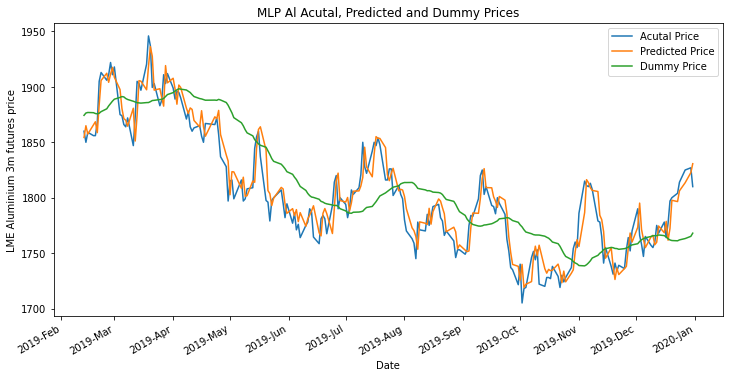

In [27]:
plotter = Security_Plotter(in_data, actual_price, predicted_price,
                            dummy_price, in_data.train_len, window_len, in_str, model_str)

plotter.single_plot()

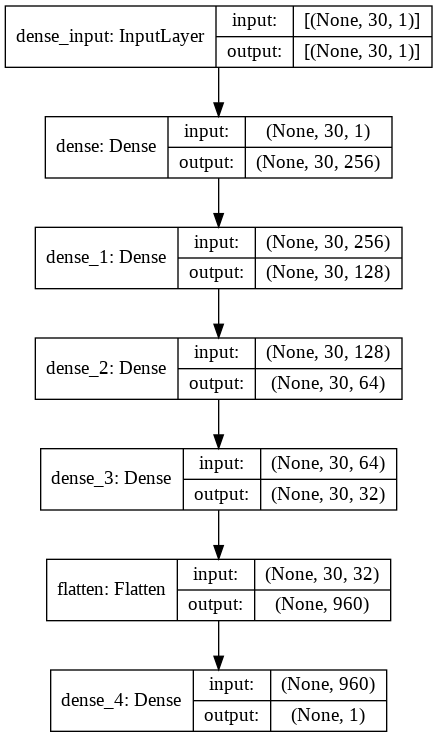

In [28]:
plot_model(model, show_shapes=True, expand_nested=True)

In [29]:
# calculating mean squared error
mse = mean_squared_error(y_true, y_pred)
d_mse = mean_squared_error(y_true, y_dummy)

# calculating root mean squared error
rmse = mean_squared_error(y_true, y_pred, squared=False)
d_rmse = mean_squared_error(y_true, y_dummy, squared=False)

# calculating mean absolute error
mae = mean_absolute_error(y_true, y_pred)
d_mae = mean_absolute_error(y_true, y_dummy)

print('MSE: ', mse)
print('RMSE: ', rmse)
print('MAE: ', mae)
print('Dummy MSE: ', d_mse)
print('Dummy RMSE: ', d_rmse)
print('Dummy MAE: ', d_mae)

MSE:  0.003844402848819651
RMSE:  0.062003248695690544
MAE:  0.049955833703626024
Dummy MSE:  0.019334874061718535
Dummy RMSE:  0.13904989774076978
Dummy MAE:  0.11616489589341868


In [30]:
# creating a string to save the model based on model name
save_path = '/content/gdrive/My Drive/models/'+model_str+'_'+in_str+'/'
# mounting google drive for easy storage of model
from google.colab import drive
# mounting the drive
drive.mount('/content/gdrive/')
# making the relevant directory to store the model
os.mkdir(save_path)
# saving the model
keras.models.save_model(model, save_path)
# saving the model graph
model_graph = plot_model(model, to_file=save_path+model_str+'_'+in_str+'_graph_.png', show_shapes=True, expand_nested=True)
# saving the matplotlib plot
plotter.fig.savefig(save_path+model_str+'_'+in_str+'_plot.png', bbox_inches='tight')
# saving the error metrics as a text file
error_file = open(save_path+model_str+'_'+in_str+'_metrics.txt', 'w+')
error_file.write('MSE: '+str(mse)+'\n'+'RMSE: '+str(rmse)+'\n'+'MAE: '+str(mae)+'\n'+
                 'Dummy MSE: '+str(d_mse)+'\n'+'Dummy RMSE: '+str(d_rmse)+'\n'+'Dummy MAE: '+str(d_mae))
error_file.close()

Mounted at /content/gdrive/
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/MLP_Al/assets
